# Adaptive Filtering-Detecting a Maneuver
Before we discuss how to create an adaptive filter we have to ask "how do we detect a maneuver?" We cannot reasonably adapt a filter to respond to maneuvers if we do not know when a maneuver is happening.

We have been defining maneuver as the time when the tracked object is accelerating, but in general we can say that the object is maneuvering with respect to the Kalman filter if its behavior is different than the process model being used by the filter.

What is the mathematical consequence of a maneuvering object for the filter? The object will be behaving differently than predicted by the filter, so the residual will be large. Recall that the residual is the difference between the current prediction of the filter and the measurement.

In [1]:
from kf_book.adaptive_internal import plot_track_and_residuals
import kf_book.book_plots as bp
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, radians

In [2]:
def show_residual_chart():
    dt = 0.1
    sensor_std = 0.2
    
    # initialize filter
    cvfilter = make_cv_filter(dt, sensor_std)
    initialize_filter(cvfilter)
    pos2, zs2 = generate_data(150, sensor_std)
    xs2 = pos2[:, 0]
    z_xs2 = zs2[:, 0]

    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    xs, res = [], []
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        xs.append(cvfilter.x[0])
        res.append(cvfilter.y[0])
        
    xs = np.asarray(xs)
    plot_track_and_residuals(dt, xs, z_xs2, res)

In [3]:
def angle_between(x, y):
    return min(y-x, y-x+360, y-x-360, key=abs)

In [4]:
class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
        
        
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)
        

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, 
                                       self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
            
            
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0

In [5]:
class NoisySensor(object):
    def __init__(self, std_noise=1.):
        self.std = std_noise

    def sense(self, pos):
        """Pass in actual position as tuple (x, y).       
        Returns position with noise added (x,y)"""
        
        return (pos[0] + (randn() * self.std), pos[1] + (randn() * self.std))

In [6]:
def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

In [7]:
def make_cv_filter(dt, std):
    cvfilter = KalmanFilter(dim_x = 2, dim_z=1)
    cvfilter.x = np.array([0., 0.])
    cvfilter.P *= 3
    cvfilter.R *= std**2
    cvfilter.F = np.array([[1, dt],
                           [0,  1]], dtype=float)
    cvfilter.H = np.array([[1, 0]], dtype=float)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    return cvfilter

In [8]:
def initialize_filter(kf, std_R=None):
    """ helper function - we will be reinitialing the filter
    many times.
    """
    kf.x.fill(0.)
    kf.P = np.eye(kf.dim_x) * .1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

Let's plot the residual for the filter during the maneuver. I will reduce the amount of noise in the data to make it easier to see the residual.

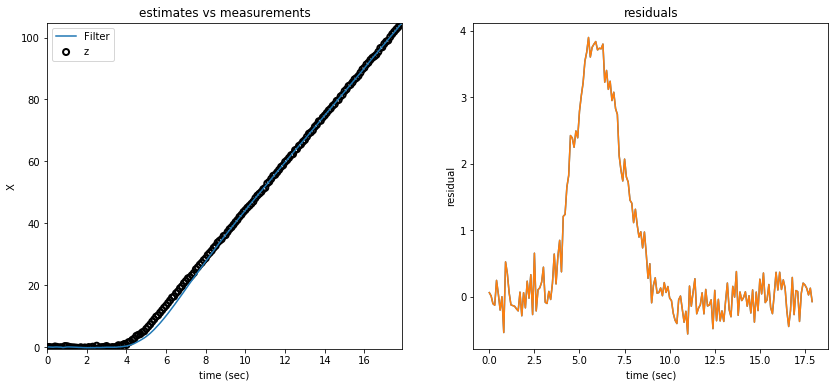

In [9]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

show_residual_chart();

On the left I have plotted the noisy measurements against the Kalman filter output. On the right I display the residuals computed by the filter - the difference between the measurement and the predictions made by the Kalman filter. Let me emphasize this to make this clear. The plot on the right is not merely the difference between the two lines in the left plot. The left plot shows the difference between the measurements and the final Kalman filter output, whereas the right plot shows us the difference **between the measurements and the predictions** of the process model.

That may seem like a subtle distinction, but from the plots you see it is not. The amount of deviation in the left plot when the maneuver starts is small, but the deviation in the right plot tells a different story. If the tracked object was moving according to the process model the residual plot should bounce around 0.0. This is because the measurements will be obeying the equation

$$\mathtt{measurement} = \mathtt{process\_model}(t) + \mathtt{noise}(t)$$

Once the target starts maneuvering the predictions of the target behavior will not match the behavior as the equation will be

$$\mathtt{measurement} = \mathtt{process\_model}(t) + \mathtt{maneuver\_delta}(t) + \mathtt{noise}(t)$$

Therefore if the residuals diverge from a mean of 0.0 we know that a maneuver has commenced.

We can see from the residual plot that we have our work cut out for us. We can clearly see the result of the maneuver in the residual plot, but the amount of noise in the signal obscures the start of the maneuver. This is our age old problem of extracting the signal from the noise.

# 1. Adjustable Process Noise
The first approach we will consider will use a lower order model and adjust the process noise based on whether a maneuver is occurring or not. When the residual gets "large" (for some reasonable definition of large) we will increase the process noise. This will cause the filter to favor the measurement over the process prediction and the filter will track the signal closely. When the residual is small we will then scale back the process noise.

## 1.1 Continuous Adjustment
The first method (from Bar-Shalom) normalizes the square of the residual using the following equation:

$$ \epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$$

where $\mathbf{y}$ is the residual and $\mathbf{S}$ is the measurement covariance, which has the equation

$$\mathbf{S} = \mathbf{HPH^\mathsf{T}} + \mathbf{R}$$
If the linear algebra used to compute this confuses you, recall that we can think of matrix inverses in terms of division, so $\epsilon = \mathbf{y^\mathsf{T}S}^{-1}\mathbf{y}$ can be thought of as computing

$$\epsilon\approx\frac{\mathbf{y}^2}{\mathbf{S}}$$

Both $\mathbf{y}$ and $\mathbf{S}$ are attributes of filterpy.KalmanFilter so implementation will be straightforward.

Let's look at a plot of $\epsilon$ against time.

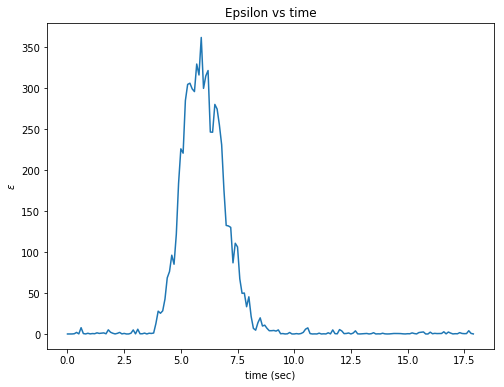

In [10]:
from numpy.linalg import inv
dt = 0.1
sensor_std = 0.2
cvfilter= make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(150, sensor_std)

epss = []
for z in zs2[:, 0]:
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = np.dot(y.T, inv(S)).dot(y)
    epss.append(eps)

t = np.arange(0, len(epss) * dt, dt)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.plot(t, epss)
bp.set_labels(title='Epsilon vs time', 
              x='time (sec)', y='$\epsilon$')

This plot should make clear the effect of normalizing the residual. Squaring the residual ensures that the signal is always greater than zero, and normalizing by the measurement covariance scales the signal so that we can distinguish when the residual is markedly changed relative to the measurement noise. The maneuver starts at t=3 seconds, and we can see that $\epsilon$ starts to increase rapidly not long after that.

We will want to start scaling $\mathbf{Q}$ up once $\epsilon$ exceeds some limit, and back down once it again falls below that limit. We multiply $\mathbf{Q}$ by a scaling factor. Perhaps there is literature on choosing this factor analytically; I derive it experimentally. We can be somewhat more analytical about choosing the limit for $\epsilon$ (named $\epsilon_{max}$) - generally speaking once the residual is greater than 3 standard deviations or so we can assume the difference is due to a real change and not to noise. However, sensors are rarely truly Gaussian and so a larger number, such as 5-6 standard deviations is used in practice.

I have implemented this algorithm using reasonable values for $\epsilon_{max}$ and the $\mathbf{Q}$ scaling factor. To make inspection of the result easier I have limited the plot to the first 10 seconds of simulation.

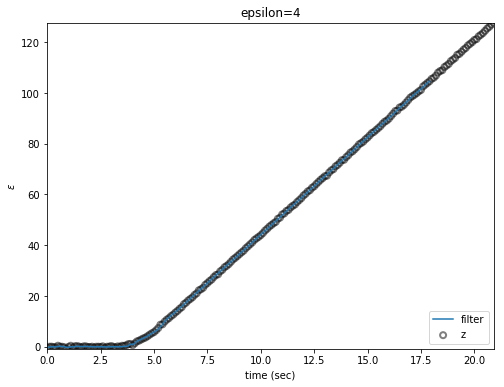

In [11]:
# reinitialize filter
dt = 0.1
sensor_std = 0.2
cvfilter = make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(180, sensor_std)

Q_scale_factor = 1000.
eps_max = 4.

xs, epss = [], []

count = 0
for i, z in zip(t, zs2[:, 0]):
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = np.dot(y.T, inv(S)).dot(y)
    epss.append(eps)
    xs.append(cvfilter.x[0])

    if eps > eps_max:
        cvfilter.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        cvfilter.Q /= Q_scale_factor
        count -= 1

bp.plot_measurements(zs2[:,0], dt=dt, label='z', alpha=0.5)
bp.plot_filter(t, xs, label='filter')
plt.legend(loc=4)
bp.set_labels(title='epsilon=4', x='time (sec)', y='$\epsilon$')

The performance of this filter is markedly better than the constant velocity filter. The constant velocity filter took roughly 10 seconds to reacquire the signal after the start of the maneuver. The adaptive filter takes under a second to do the same.

## 1.2 Continuous Adjustment - Standard Deviation Version
Another, very similar method from Zarchan [2] sets the limit based on the standard deviation of the measurement error covariance. Here the equations are:

$$ \begin{aligned}
std &= \sqrt{\mathbf{HPH}^\mathsf{T} + \mathbf{R}} \\
    &= \sqrt{\mathbf{S}}
\end{aligned}
$$

If the absolute value of the residual is more than some multiple of the standard deviation computed above we increase the process noise by a fixed amount, recompute Q, and continue.

In [12]:
from math import sqrt

In [13]:
def zarchan_adaptive_filter(Q_scale_factor, std_scale, 
                            std_title=False,
                            Q_title=False):
    cvfilter = make_cv_filter(dt, std=0.2)
    pos2, zs2 = generate_data(180-30, std=0.2)
    xs2 = pos2[:,0]
    z_xs2 = zs2[:,0]

    # reinitialize filter
    initialize_filter(cvfilter)
    cvfilter.R = np.eye(1)*0.2

    phi = 0.02
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=phi)
    xs, ys = [], []
    count = 0
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        y = cvfilter.y
        S = cvfilter.S
        std = sqrt(S)

        xs.append(cvfilter.x)
        ys.append(y)

        if abs(y[0]) > std_scale*std:
            phi += Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
            count += 1
        elif count > 0:
            phi -= Q_scale_factor
            cvfilter.Q = Q_discrete_white_noise(2, dt, phi)
            count -= 1

    xs = np.asarray(xs)
    plt.subplot(121)
    bp.plot_measurements(z_xs2, dt=dt, label='z')
    bp.plot_filter(xs[:, 0], dt=dt, lw=1.5)
    bp.set_labels(x='time (sec)', y='$\epsilon$')
    plt.legend(loc=2)
    if std_title:
        plt.title('position(std={})'.format(std_scale))
    elif Q_title:
        plt.title('position(Q scale={})'.format(Q_scale_factor))
    else:
        plt.title('position')
        
    plt.subplot(122)
    plt.plot(np.arange(0, len(xs)*dt, dt), xs[:, 1], lw=1.5)
    plt.xlabel('time (sec)')
    if std_title:
        plt.title('velocity(std={})'.format(std_scale))
    elif Q_title:
        plt.title('velocity(Q scale={})'.format(Q_scale_factor))
    else:
        plt.title('velocity')        
    plt.show()

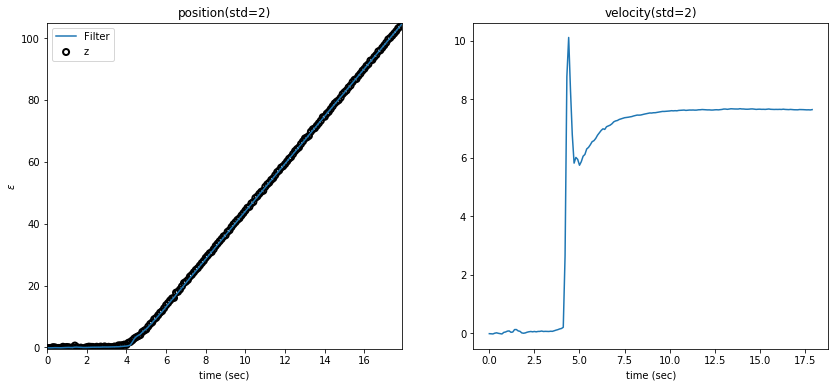

In [14]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

zarchan_adaptive_filter(1000, 2, std_title=True)

So I chose to use 1000 as the scaling factor for the noise, and 2 as the standard deviation limit. Why these numbers? Well, first, let's look at the difference between 2 and 3 standard deviations.

#### Two Standard Deviations

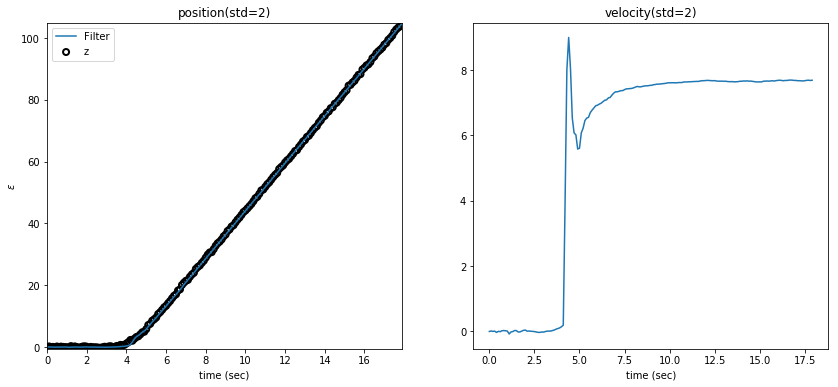

In [15]:
zarchan_adaptive_filter(1000, 2, std_title=True)

#### Three Standard Deviations

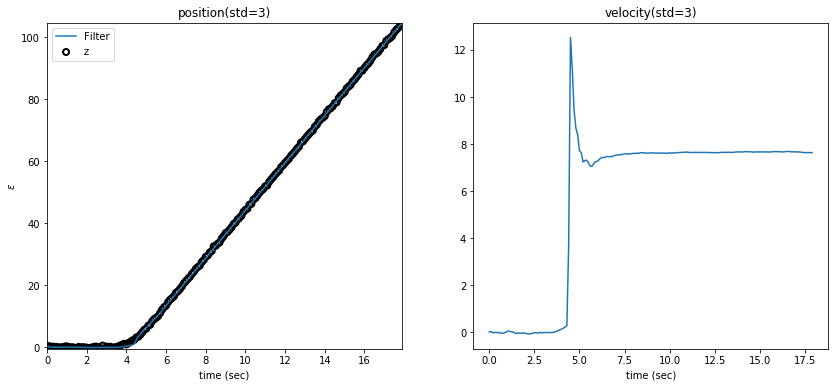

In [16]:
zarchan_adaptive_filter(1000, 3, std_title=True)

We can see from the charts that the filter output for the position is very similar regardless of weather we use 2 standard deviations or three. But the computation of the velocity is a different matter. Let's explore this further. First, let's make the standard deviation very small.

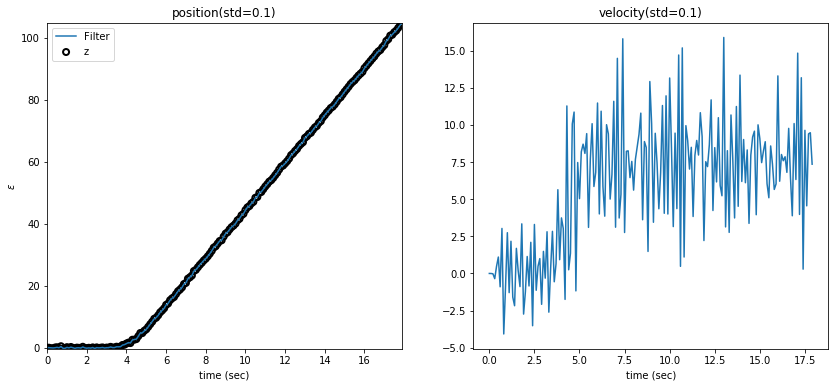

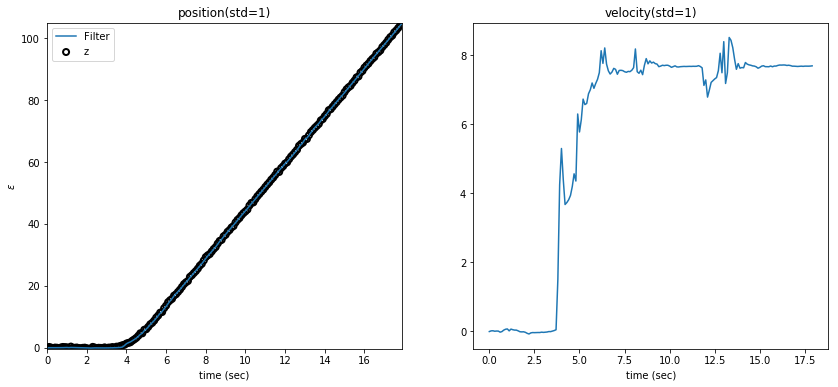

In [17]:
zarchan_adaptive_filter(1000, .1, std_title=True)
zarchan_adaptive_filter(1000, 1, std_title=True)

As the standard deviation limit gets smaller the computation of the velocity gets worse. Think about why this is so. If we start varying the filter so that it prefers the measurement over the prediction as soon as the residual deviates even slightly from the prediction we very quickly be giving almost all the weight towards the measurement. With no weight for the prediction we have no information from which to create the hidden variables. So, when the limit is 0.1 std you can see that the velocity is swamped by the noise in the measurement. On the other hand, because we are favoring the measurements so much the position follows the maneuver almost perfectly.

Now let's look at the effect of various increments for the process noise. Here I have held the standard deviation limit to 2 std, and varied the increment from 1 to 10,000.

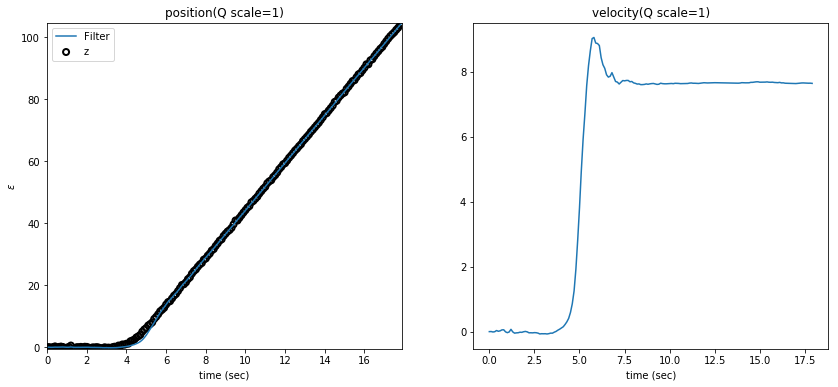

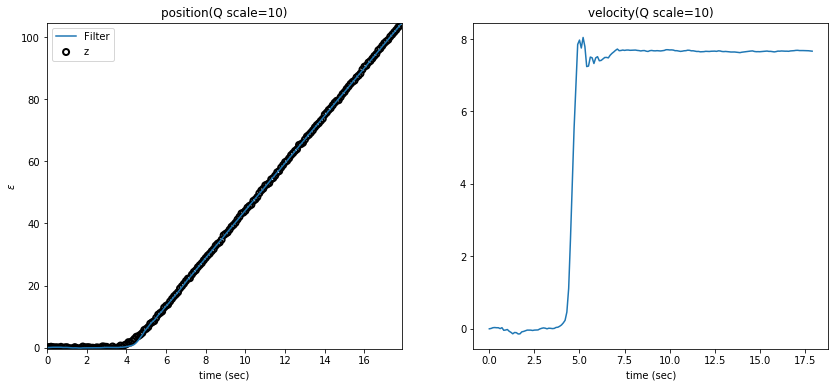

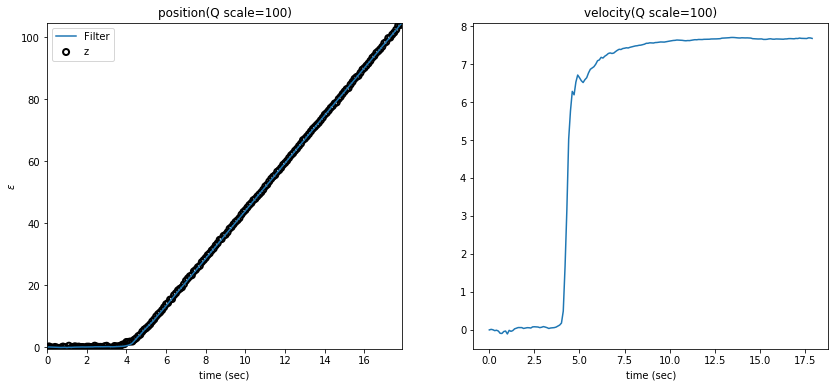

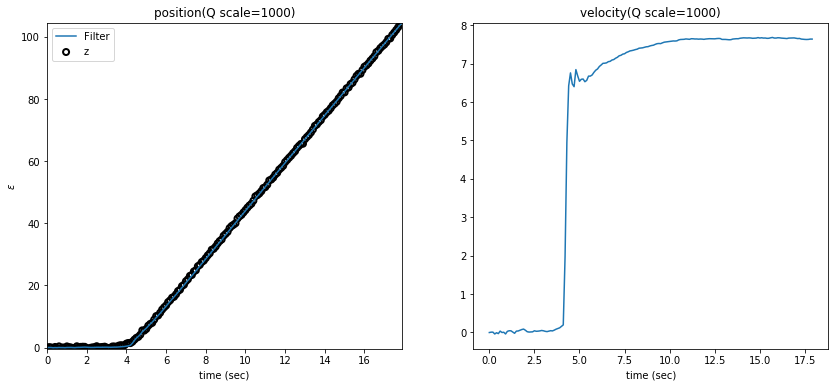

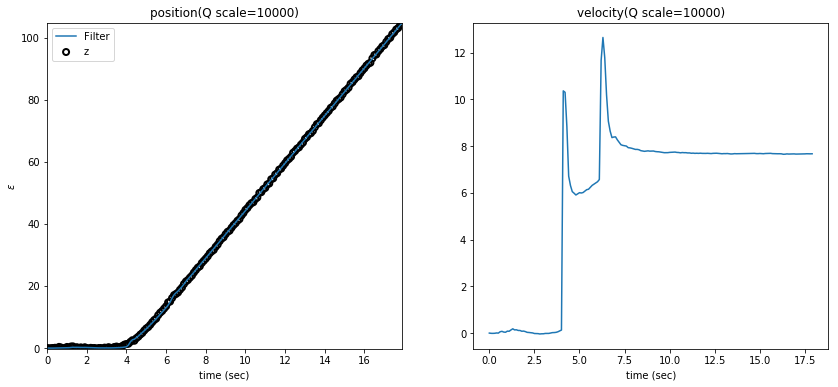

In [18]:
zarchan_adaptive_filter(1, 2, Q_title=True)
zarchan_adaptive_filter(10, 2, Q_title=True)
zarchan_adaptive_filter(100, 2, Q_title=True)
zarchan_adaptive_filter(1000, 2, Q_title=True)
zarchan_adaptive_filter(10000, 2, Q_title=True)

Here we can see that the position estimate gets marginally better as the increment factor increases, but that the velocity estimate starts to create a large overshoot.

It isn't possible for me to tell you which of these is 'correct'. You will need to test your filter's performance against real and simulated data, and choose the design that best matches the performance you need for each of the state variables.

# 2. Fading Memory Filter
Fading memory filters are not normally classified as an adaptive filter since they do not adapt to the the input, but they do provide good performance with maneuvering targets. They also have the benefit of having a very simple computational form for first, second, and third order kinematic filters (e.g. the filters we are using in this chapter). This simple form does not require the Ricatti equations to compute the gain of the Kalman filter, which drastically reduces the amount of computation. However, there is also a form that works with the standard Kalman filter. I will focus on the latter in this chapter since our focus is more on adaptive filters. Both forms of the fading memory filter are implemented in ```FilterPy```.

The Kalman filter is recursive, but it incorporates all of the previous measurements into the current computation of the filter gain. If the target behavior is consistent with the process model than this allows the Kalman filter to find the optimal estimate for every measurement. Consider a ball in flight - we can clearly estimate the position of the ball at time t better if we take into account all the previous measurement. If we only used some of the measurements we would be less certain about the current position, and thus more influenced by the noise in the measurement. If this is still not clear, consider the worst case. Suppose we forget all but the last measurement and estimates. We would then have no confidence in the position and trajectory of the ball, and would have little choice but to weight the current measurement heavily. If the measurement is noisy, the estimate is noisy. We see this effect every time a Kalman filter is initialized. The early estimates are noisy, but then they settle down as more measurements are acquired.

However, if the target is maneuvering it is not always behaving like the process model predicts. In this case remembering all of the past measurements and estimates is a liability. We can see this in all of the charts above. The target initiates a turn, and the Kalman filter continues to project movement in a straight line. This is because the filter has built a history of the target's movement, and incorrectly 'feels' confident that the target is moving in a straight line at a given heading and velocity.

The fading memory filter accounts for this problem by giving less weight to older measurements, and greater weight to the more recent measurements.

There are many formulations for the fading memory filter; I use the one provided by Dan Simon in Optimal State Estimation. I will not go through his derivation, but only provide the results.

The Kalman filter equation for the covariances of the estimation error is

$$ \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q $$

We can force the filter to forget past measurements by multiplying a term $\alpha$

$$ \tilde{\mathbf P} = \alpha^2\mathbf{FPF}^\mathsf T + \mathbf Q$$

where $\alpha \gt 1.0$. If $\alpha == 1$ then we get the normal Kalman filter performance. $\alpha$ is an attribute of the KalmanFilter class; its value defaults to 1 so the filter acts like a Kalman filter unless $\alpha$ is assigned a value other than 1. There is no hard and fast rule for choosing $\alpha$, but it is typically very close to 1, such as 1.01. You will need to make many runs with either simulated or real data to determine a value that responds to maneuvers without causing the estimate to become too noisy due to overly weighting the noisy measurement.

Why does this work? If we increase the estimate error covariance the filter becomes more uncertain about it's estimate, hence it gives more weight to the measurement.

One caveat - if we use $\alpha$ than we are computing $\tilde{\mathbf P}$, not $\bar{\mathbf P}$. In other words, KalmanFilter.P is not equal to the covariance of the prior, so do not treat it as if it is.

Let's filter our data using the fading memory filter and see the result. I will inject a lot of error into the system so that we can compare various approaches.

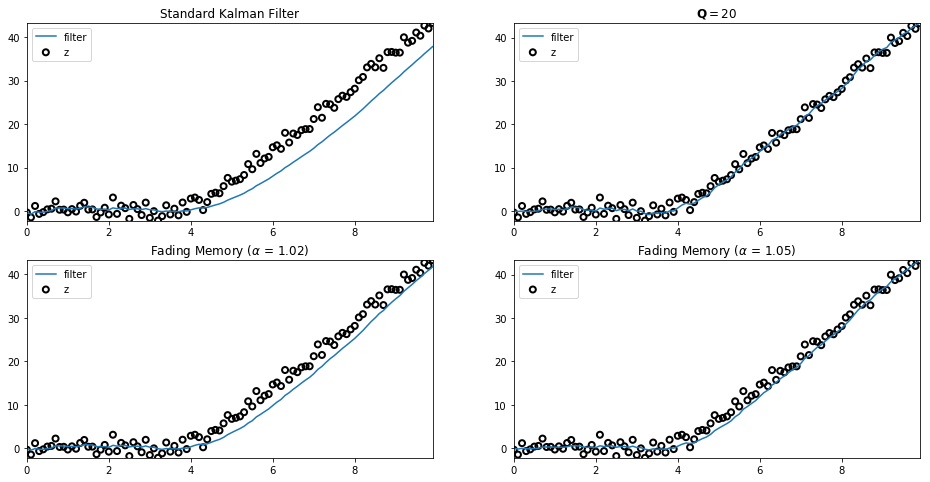

In [19]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size


pos2, zs2 = generate_data(70, std=1.2)
xs2 = pos2[:, 0]
z_xs2 = zs2[:, 0]

cvfilter = make_cv_filter(dt, std=1.2)
cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.00

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(221)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Standard Kalman Filter')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=20.)
cvfilter.alpha = 1.00

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
    
xs = np.asarray(xs)

plt.subplot(222)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('$\mathbf{Q}=20$')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.02

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(223)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.02)')

cvfilter.x.fill(0.)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
cvfilter.alpha = 1.05

xs, res = [], []
for z in z_xs2:
    cvfilter.predict()
    cvfilter.update([z])
    xs.append(cvfilter.x[0])
    res.append(cvfilter.y[0])
xs = np.asarray(xs)
plt.subplot(224)
bp.plot_measurements(z_xs2, dt=dt, label='z')
plt.plot(t[0:100], xs, label='filter')
plt.legend(loc=2)
plt.title('Fading Memory ($\\alpha$ = 1.05)');

The first plot shows the performance of the Kalman filter. The filter diverges when the maneuver starts and does not reacquire the signal until about 10 seconds. I then made the filter track the maneuver very quickly by making the process noise large, but this has the cost of making the filter estimate very noisy due to unduly weighting the noisy measurements. I then implemented a fading memory filter with $\alpha=1.02$. The filtered estimate is very smooth, but it does take a few seconds to converge when the target regains steady state behavior. However, the time to do so is considerably smaller than for the Kalman filter, and the amount of lag is much smaller - the estimate for the fading memory is much closer to the actual track than the Kalman filter's track is. Finally, I bumped up $\alpha$ to 1.05. Here we can see that the filter responds almost instantly to the maneuver, but that the estimate is not as straight during the steady state operation because the filter is forgetting the past measurements.

This is quite good performance for such a small change in code! Note that there is no 'correct' choice here. You will need to design your filter based on your needs and the characteristics of the measurement noise, process noise, and maneuvering behavior of the target.